#Pecan validation analysis

Here we perform analysis on the model vs ground truth data for thermal and occupancy consumption. We contrast two models:
* ground truth thermal response: a locally-weighted regression model using separately-monitored HVAC and temperature
* the HMM thermal model

##Initializations

In [1]:
rm(list = ls())

In [2]:
options(error = recover)
library('segmented')
library('lubridate')
library('ggplot2')
library(zoo)
library('reshape2')
library('PerformanceAnalytics')
library('RColorBrewer')
library('pracma')
library('fields')


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: xts

Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend

Loading required package: spam
Loading required package: grid
Spam version 1.0-1 (2014-09-09) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps


In [3]:
setwd("~/EnergyAnalytics/thermal_profiles/")
source("validator/drank.r")

In [4]:
DATA_PATH = '~/S3L_server/energy-data/pecan_street/usage-select/'
DUMP_PATH = '~/S3L_server/energy-data/pecan_street/models_new/'
PLOT_PATH = '~/S3L_server/plots/pecan-street-new/'
MODEL_PATH= '~/S3L_server/energy-data/pecan_street/models_new/'

Paths to original data

In [6]:
# load user names
user_names = read.csv('~/S3L_server/energy-data/pecan_street/metadata/user_names_ids.csv')
user_names$X = NULL

# list all data files
files    = list.files(path=DATA_PATH, full.names = T, recursive = T)
files_01 = files[grep('01min',files)]
files_15 = files[grep('15min',files)]
files_60 = files[grep('60min',files)]

# extract ID
users_df = data.frame(UID = as.character(sapply(files_60, function(s) strsplit(tail(strsplit(s, '/')[[1]], 1), '\\.')[[1]][1])))
rownames(users_df) = NULL
    
# build original data sources dataframe
users_df = merge(users_df, user_names, by.x="UID", by.y="ID")
users_df['01min'] = files_01
users_df['15min'] = files_15
users_df['60min'] = files_60
users_df = melt(users_df, id=c("UID","name"))
names(users_df)[c(3,4)] = c("grain", "file_orig")  
print(paste("There are", nrow(users_df), "original data files"))

[1] "There are 1098 original data files"


In [7]:
users_df[1,]

,UID,name,grain,file_orig
1,1069,Edd,01min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//01min/1069.csv


Paths to thermal models data

In [8]:
# models 
files_dec = list.files(path=MODEL_PATH, pattern="*decoded", full.names = T, recursive = T)
files_int = list.files(path=MODEL_PATH, pattern="*interpreted", full.names = T, recursive = T)
f_dum = function(x) {
    tmp = tail(strsplit(x, '/')[[1]],n=2)
    res = tmp[1]
    nfo = strsplit(tmp[2], "_")[[1]]
    uid = nfo[1]; name = nfo[2]; 
    return(c(uid,name,res,x))
}
model_paths_dec = data.frame(do.call('rbind', lapply(files_dec, f_dum)))
model_paths_int = data.frame(do.call('rbind', lapply(files_int, f_dum)))

if (length(model_paths_dec)>0) names(model_paths_dec) <- c("UID", "name", "grain", "file_model")
if (length(model_paths_int)>0) names(model_paths_int) <- c("UID", "name", "grain", "file_model")
model_paths = merge(model_paths_dec, model_paths_int, by=c("UID", "name", "grain"), suffixes=c("_decode", "_interp"))

In [9]:
info_files = merge(model_paths, users_df, by=c("UID", "name", "grain"))
info_files = info_files[with(info_files, order(UID,grain,name)),]
print(paste("There are", nrow(info_files), "files"))

[1] "There are 691 files"


In [10]:
info_files[1:2,]

,UID,name,grain,file_model_decode,file_model_interp,file_orig
1,1069,Edd,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1069_Edd/15min/1069_Edd_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1069_Edd/15min/1069_Edd_interpreted.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//15min/1069.csv
2,1069,Edd,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1069_Edd/60min/1069_Edd_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1069_Edd/60min/1069_Edd_interpreted.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/1069.csv


##Load processed thermal regimes data

In [32]:
f_process_model = function(row) {
    # access decoded data    
    load(as.character(as.character(row$file_model_decode)));
    df = data$df
    nStates= data$nStates
    df     = cbind(df, data$state)
    df$TemperatureD = df$TemperatureF - 65
    resp   = data$response   
    tran   = data$transition
    tran   = lapply(unique(tran$From), function(s) {d = subset(tran, To ==s); d$From = d$To = NULL; rownames(d) = 1:nrow(d); return(d)})

    # format model parameters for easy analysis access
    volatility = lapply(1:nStates, function(s) { z = c(mu = 0, sd = resp$stdev[s]); names(z) = c('mu', 'sd'); z})
    baseload   = lapply(1:nStates, function(s) { z = c(mu = resp$means['(Intercept)', s], sd = resp$stderr['(Intercept)', s]); names(z) = c('mu', 'sd'); z})
    response   = lapply(1:nStates, function(s) c(mu = resp$means['TemperatureD', s], sd = as.numeric(resp$stderr['TemperatureD', s])))
    
    df$resp_MAP   = sapply(df$state, function(s) response[[s]]['mu'])
    df$resp_MAP.se= sapply(df$state, function(s) response[[s]]['sd'])
    tmp = df[grepl("X[1-9]", names(df))] * matrix(unlist(response), nrow=2)
    df$resp_avg   = rowSums(tmp[1,])
    df$resp_avg.se= apply(tmp[1,], 1, sd)
        
    # access "interpreted" quantities
    load(as.character(as.character(row$file_model_interp)));
    response_df = data.frame(matrix(unlist(response), nrow=2))
    names(response_df) = as.character(1:nStates)
    rownames(response_df) = c("mu", "sd")
    res = data$benchmarks$steadyDistr %*% as.matrix(t(response_df))
    resp = data.frame(TemperatureF = 1:nrow(res), 
                      resp_avg=res[,1], resp_avg.se=res[,2],
                      resp_MAP=apply(data$benchmarks$steadyDistr, 1, function(r) response[[which.max(r)]]['mu']),
                      resp_MAP.se=apply(data$benchmarks$steadyDistr, 1, function(r) response[[which.max(r)]]['sd']))
    prob_steady = data.frame(data$benchmarks$steadyDistr)
    names(prob_steady) = paste("X", 1:nStates, sep='')
    resp = cbind(resp, prob_steady)

    res = list(volatility = volatility, 
               baseload = baseload, 
               response = response_df, 
               tran = tran, 
               nStates = nStates,
               resp_profile = resp,
               data = df)
    gc()
    return(res)
}

In [76]:
row = info_files[3,]
res = f_process_model(row)
head(res$data)

,obs,TemperatureD,TemperatureF,timestamps,state,X1,X2,fit,fit.max,resp_MAP,resp_MAP.se,resp_avg,resp_avg.se
1,0.5699333,6.1,71.1,2013-02-23 16:00:00,2,0,1,0.6526393,0.6526393,0.00262043,6.661618e-05,0.00262043,0.001852924
2,0.9321333,5.993333,70.99333,2013-02-23 16:15:00,2,0.007994675,0.9920053,0.6633052,0.6523598,0.00262043,6.661618e-05,0.00262043,0.001852924
3,1.122333,6.013333,71.01333,2013-02-23 16:30:00,1,0.1570562,0.8429438,0.86753,2.022099,0.03272398,0.0002537432,0.00262043,0.001852924
4,1.1332,6.233333,71.23333,2013-02-23 16:45:00,1,0.4040097,0.5959903,1.209031,2.029299,0.03272398,0.0002537432,0.00262043,0.001852924
5,1.4596,5.826667,70.82667,2013-02-23 17:00:00,1,0.9998827,0.0001173473,2.015831,2.015991,0.03272398,0.0002537432,0.00262043,0.001852924
6,1.277667,5.506667,70.50667,2013-02-23 17:15:00,1,0.998617,0.001383019,2.003646,2.005519,0.03272398,0.0002537432,0.00262043,0.001852924


In [161]:
f_estimate_empirical_prob = function(temp_df){
    temp_df = temp_df[,c("TemperatureF", "state")]
    temp_df = temp_df[with(temp_df, order(TemperatureF)),]
    resp_est_df = data.frame(TemperatureF = 1:120)
    n = length(unique(temp_df$state))
    prof_est = sapply(1:120, function(t){
        cur_df = subset(temp_df, (TemperatureF >= t-1) & (TemperatureF <= t+1))
        tmp = rep(0,n); names(tmp) = as.character(1:n)
        tab = table(cur_df$state)/nrow(cur_df)
        tmp[names(tab)] = tab
        return(t(tmp))
    })
    prof_est = t(prof_est)
    names(prof_est) = paste("X", 1:n)
    prof_est = data.frame(prof_est)
    prof_est$TemperatureF = 1:120
    gc()
    return(prof_est)
}

In [162]:
prof_est = f_estimate_empirical_prob(res$data)
head(prof_est)

ERROR: Error in order(TemperatureF): object 'TemperatureF' not found


recover called non-interactively; frames dumped, use debugger() to view


ERROR: Error in head(prof_est): error in evaluating the argument 'x' in selecting a method for function 'head': Error: object 'prof_est' not found



In [79]:
f_plot_prob_profiles = function(prof_est, prof_steady) {
    nStates = ncol(prof_est)-1
    # define colors
    add.alpha <- function(col, alpha=1){
      if(missing(col))
        stop("Please provide a vector of colours.")
      apply(sapply(col, col2rgb)/255, 2, 
                         function(x) 
                           rgb(x[1], x[2], x[3], alpha=alpha))  
    }
    cols <- brewer.pal(nStates,"Dark2")
    colsAlpha = add.alpha(cols, 0.3)
            
    # produce plots
    plot(prof_est$TemperatureF, prof_est$X1, col=colsAlpha[1], type = 'b', lwd=3, 
         cex.main=1.8, 
         cex.lab=1.5,
         cex.axis=1.5,
         ylim=c(0,1),
         main="Thermal Regime Temperature Profile", 
         xlab="Temperature (deg F)", ylab="P(S=j;T)")
    points(prof_steady$TemperatureF, prof_steady$X1, col=cols[1], type = 'l', lty=1, lwd=5)
    for (n in 2:nStates){ 
        points(prof_est$TemperatureF, prof_est[,paste("X",n,sep="")], col=colsAlpha[n], type = 'b', lwd=3)
        points(prof_steady$TemperatureF, prof_steady[,paste("X",n,sep="")], col=cols[n], type = 'l', lty=1, lwd=5)
    }

    legend("right", sprintf("P(S=%d)",1:nStates), col=cols, lty=1, lwd=4)
    gc()
}

Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,653360,34.9,1442291,77.1,1442291,77.1
Vcells,2741359,21,78328568,597.6,1506255792,11491.9


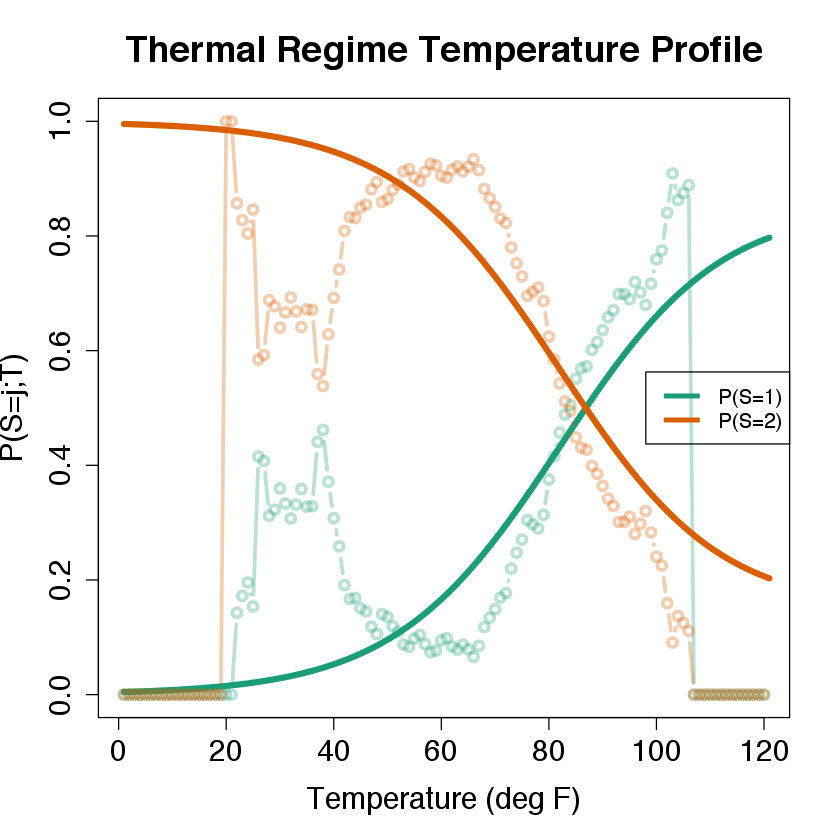

In [80]:
f_plot_prob_profiles(prof_est, res$resp_profile)

##Estimate "ground truth" thermal response

In [105]:
# format data to match the observations available for thermal modeling
f_estimate_GT_resp = function(row, timestamps){
    df_orig = read.csv(as.character(row$file_orig))
    df_orig$HVAC = 0
    if ('HV' %in% names(df_orig)) df_orig$HVAC = df_orig$HVAC + df_orig$HV
    if ('AC' %in% names(df_orig)) df_orig$HVAC = df_orig$HVAC + df_orig$AC
    df_orig$TemperatureD = df_orig$TemperatureF - 65
    df_orig = subset(df_orig, date %in% timestamps)
    
    temp_vec = 1:120
    df_resp = data.frame(TemperatureF = temp_vec)

    fit                 = lowess(df_orig$TemperatureF, df_orig$HVAC) 
    plx_grid            = approx(fit$x, fit$y, temp_vec)
    df_resp$fit_HVAC    = na.locf(na.locf(plx_grid$y, na.rm=FALSE), fromLast=TRUE)
    df_resp$resp_HVAC   = na.locf(na.locf(c(NA,diff(plx_grid$y)), na.rm=FALSE), fromLast=TRUE)
    df_orig$resp_HVAC   = fit$y

    # learn "ground truth" thermal response for HV and AC
    if ('HV' %in% names(df_orig))
        fit               = lowess(df_orig$TemperatureF, df_orig$HV) 
        plx_grid          = approx(fit$x, fit$y, temp_vec)
        df_resp$fit_HV    = na.locf(na.locf(plx_grid$y, na.rm=FALSE), fromLast=TRUE)
        df_resp$resp_HV   = na.locf(na.locf(c(NA,diff(plx_grid$y)), na.rm=FALSE), fromLast=TRUE)
        df_orig$resp_HV   = fit$y

    if ('AC' %in% names(df_orig))
        fit               = lowess(df_orig$TemperatureF, df_orig$AC) 
        plx_grid          = approx(fit$x, fit$y, temp_vec)
        df_resp$fit_AC    = na.locf(na.locf(plx_grid$y, na.rm=FALSE), fromLast=TRUE)
        df_resp$resp_AC   = na.locf(na.locf(c(NA,diff(plx_grid$y)), na.rm=FALSE), fromLast=TRUE)
        df_orig$resp_AC   = fit$y
        
    gc()
    return(list(df_orig = df_orig, df_resp = df_resp))
}
        

##Produce visualizations

Plot ground truth response for HV/AC on same graph


In [156]:
f_plot_GT_profile = function(df_orig, df_resp){
    plot(df_orig$TemperatureF, df_orig$HVAC, pch ='.', cex=0, col = rgb(1, 1, 1, 0.5),
        cex.main=2, main="Ground Truth Temperature Profile", 
        cex.lab=1.5,
        cex.axis=1.2, xlab="Temperature (deg F)", ylab="Ground Truth HVAC (kWh)")

    if ('HV' %in% names(df_orig))
        points(df_orig$TemperatureF, df_orig$HV, pch ='.', cex=2.5, col = rgb(0, 0, 1, 0.5))
        lines(df_resp$TemperatureF, df_resp$fit_HV, type='l', col='blue', lwd=4, xlab="")

    if ('AC' %in% names(df_orig))
        points(df_orig$TemperatureF, df_orig$AC, pch ='.', cex=2.5, col = rgb(1, 0, 0, 0.5))
        lines(df_resp$TemperatureF, df_resp$fit_AC, type='l', col='red', lwd=4, xlab="")
    legend("bottomright", intersect(c("AC", "HV"), names(df_orig)), 
       lty=c(1,1), # gives the legend appropriate symbols (lines)
       lwd=c(2.5,2.5),col=c("red","blue"),
       cex=1.5)

    gc()
}

Plot response profiles

In [172]:
f_plot_response = function(df_resp, df_orig){
    v = c(df_resp$resp_HVAC, df_resp$resp_avg)
    if ('AC' %in% names(df_orig)) v = c(v, df_resp$resp_AC)
    if ('HV' %in% names(df_orig)) v = c(v, df_resp$resp_HV)
    ylim_resp = range(v)
    plot(df_resp$TemperatureF, df_resp$resp_HVAC, col='green', type='l', lwd=5, 
         cex.main=2, 
         cex.lab=1.5,
         cex.axis=1.2, 
         ylim=ylim_resp,
         main="Ground Truth Thermal Response", 
         xlab="Temperature (deg F)", ylab="Response (kwh/deg F)")
    
    if ('AC' %in% names(df_orig))
        points(df_resp$TemperatureF, df_resp$resp_AC, col='red', type='l', lwd=5) 

    if ('HV' %in% names(df_orig))
        points(df_resp$TemperatureF, df_resp$resp_HV, col='blue', type='l', lwd=5) 

    points(df_resp$TemperatureF, df_resp$resp_avg, col='black', type='l', lwd=5)
    cols = c("green", "red","blue", "black"); names(cols) = c("HVAC", "AC", "HV", "Model")
    legend("topleft", c(intersect(c("HVAC", "AC", "HV"), names(df_orig)), "Model"), 
           lty=c(1,1), # gives the legend appropriate symbols (lines)
           lwd=c(2.5,2.5),col=cols[c(intersect(c("HVAC", "AC", "HV"), names(df_orig)), "Model")],
           cex=1.5)
    abline(h=0, lwd = 2, col='black')
    gc()
}


##Process data

In [173]:
f_wrapper = function(i) {
    res_HMM = f_process_model(row)                   # load & process data from HMM model
    times_ok= res_HMM$data$timestamps
    res_GTH = f_estimate_GT_resp(row, times_ok)      # compute "ground truth" fit
    prof_HMM= f_estimate_empirical_prob(res_HMM$data)# estimate empirical probabil

    df_resp_HMM = res_HMM$resp_profile
    df_resp_GTH = res_GTH$df_resp
    df_resp = cbind(df_resp_HMM[-nrow(df_resp_HMM),], df_resp_GTH[,-1])
    df_resp$grain = row$grain
    df_resp$name  = row$name
    df_resp$UID   = row$UID
     
    # plot model regime probability profile
    user_info = paste(row$UID, row$name, sep="_")
    fname_1 = paste(PLOT_PATH, user_info, paste(user_info, row$grain, "state_prob_profile.pdf",sep='_'), sep='/')
    if (file.exists(fname_1)) file.remove(fname_1)
    pdf(file = fname_1, 7, 5)
    f_plot_prob_profiles(prof_HMM, res_HMM$resp_profile)
    dev.off()
    
    # plot ground truth estimation of response profiles
    fname_2 = paste(PLOT_PATH, user_info, paste(user_info, row$grain, "ground_truth_response.pdf",sep='_'),sep='/')
    if (file.exists(fname_2)) file.remove(fname_2)
    pdf(file = fname_2, 7, 5)
    f_plot_response(df_resp, res_GTH$df_orig)
    dev.off()
    
    # plot response profiles on same axis (ground truth, HMM)
    fname_3 = paste(PLOT_PATH, user_info, paste(user_info, row$grain, "all_response_profiles.pdf",sep='_'),sep='/')
    if (file.exists(fname_3)) file.remove(fname_3)
    pdf(file = fname_3, 7, 5)
    f_plot_GT_profile(res_GTH$df_orig, res_GTH$df_resp)
    dev.off()
    gc()
    return(df_resp)
}

In [174]:
thermal_model = list()
for (i in 1:nrow(info_files)) {
    row <- info_files[i,]
    print(paste("Processing file", i, "of", nrow(info_files), ":", row$UID))
    thermal_model[[length(thermal_model)+1]] = f_wrapper(row)
}


[1] "Processing file 1 of 691 : 1069"
[1] "Processing file 2 of 691 : 1069"
[1] "Processing file 3 of 691 : 1086"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 4 of 691 : 1086"
[1] "Processing file 5 of 691 : 1105"
[1] "Processing file 6 of 691 : 1105"
[1] "Processing file 7 of 691 : 114"
[1] "Processing file 8 of 691 : 114"
[1] "Processing file 9 of 691 : 1167"
[1] "Processing file 10 of 691 : 1167"
[1] "Processing file 11 of 691 : 1169"
[1] "Processing file 12 of 691 : 1169"
[1] "Processing file 13 of 691 : 1185"
[1] "Processing file 14 of 691 : 1185"
[1] "Processing file 15 of 691 : 1283"
[1] "Processing file 16 of 691 : 1283"
[1] "Processing file 17 of 691 : 1331"
[1] "Processing file 18 of 691 : 1331"
[1] "Processing file 19 of 691 : 1334"
[1] "Processing file 20 of 691 : 1334"
[1] "Processing file 21 of 691 : 135"
[1] "Processing file 22 of 691 : 1392"
[1] "Processing file 23 of 691 : 1392"
[1] "Processing file 24 of 691 : 1450"
[1] "Processing file 25 of 691 : 1450"
[1] "Processing file 26 of 691 : 1464"
[1] "Processing file 27 of 691 : 1464"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 28 of 691 : 1479"
[1] "Processing file 29 of 691 : 1500"
[1] "Processing file 30 of 691 : 1500"
[1] "Processing file 31 of 691 : 1507"
[1] "Processing file 32 of 691 : 1507"
[1] "Processing file 33 of 691 : 1577"
[1] "Processing file 34 of 691 : 1577"
[1] "Processing file 35 of 691 : 160"
[1] "Processing file 36 of 691 : 160"
[1] "Processing file 37 of 691 : 1617"
[1] "Processing file 38 of 691 : 1617"
[1] "Processing file 39 of 691 : 1629"
[1] "Processing file 40 of 691 : 1629"
[1] "Processing file 41 of 691 : 1632"
[1] "Processing file 42 of 691 : 1632"
[1] "Processing file 43 of 691 : 1642"
[1] "Processing file 44 of 691 : 1642"
[1] "Processing file 45 of 691 : 1681"
[1] "Processing file 46 of 691 : 1681"
[1] "Processing file 47 of 691 : 1696"
[1] "Processing file 48 of 691 : 1696"
[1] "Processing file 49 of 691 : 1697"
[1] "Processing file 50 of 691 : 1697"
[1] "Processing file 51 of 691 : 1714"
[1] "Processing file 52 of 691 : 1714"
[1] "Processing file 53 of 

Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 55 of 691 : 1731"
[1] "Processing file 56 of 691 : 1731"
[1] "Processing file 57 of 691 : 1782"
[1] "Processing file 58 of 691 : 1790"
[1] "Processing file 59 of 691 : 1790"
[1] "Processing file 60 of 691 : 1801"
[1] "Processing file 61 of 691 : 1830"
[1] "Processing file 62 of 691 : 1830"
[1] "Processing file 63 of 691 : 1854"
[1] "Processing file 64 of 691 : 1947"
[1] "Processing file 65 of 691 : 1947"
[1] "Processing file 66 of 691 : 1953"
[1] "Processing file 67 of 691 : 1953"
[1] "Processing file 68 of 691 : 1994"
[1] "Processing file 69 of 691 : 1994"
[1] "Processing file 70 of 691 : 2004"
[1] "Processing file 71 of 691 : 2004"
[1] "Processing file 72 of 691 : 2018"
[1] "Processing file 73 of 691 : 2018"
[1] "Processing file 74 of 691 : 2034"
[1] "Processing file 75 of 691 : 2034"
[1] "Processing file 76 of 691 : 2062"
[1] "Processing file 77 of 691 : 2062"
[1] "Processing file 78 of 691 : 2094"
[1] "Processing file 79 of 691 : 2094"
[1] "Processing file 80 o

Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 148 of 691 : 3039"
[1] "Processing file 149 of 691 : 3044"
[1] "Processing file 150 of 691 : 3044"
[1] "Processing file 151 of 691 : 3087"
[1] "Processing file 152 of 691 : 3087"
[1] "Processing file 153 of 691 : 3092"
[1] "Processing file 154 of 691 : 3092"
[1] "Processing file 155 of 691 : 3192"
[1] "Processing file 156 of 691 : 3192"
[1] "Processing file 157 of 691 : 3221"
[1] "Processing file 158 of 691 : 3221"
[1] "Processing file 159 of 691 : 3263"
[1] "Processing file 160 of 691 : 3263"
[1] "Processing file 161 of 691 : 3273"
[1] "Processing file 162 of 691 : 3273"
[1] "Processing file 163 of 691 : 3367"
[1] "Processing file 164 of 691 : 3367"
[1] "Processing file 165 of 691 : 3392"
[1] "Processing file 166 of 691 : 3392"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 167 of 691 : 3394"
[1] "Processing file 168 of 691 : 3394"
[1] "Processing file 169 of 691 : 3411"
[1] "Processing file 170 of 691 : 3411"
[1] "Processing file 171 of 691 : 3425"
[1] "Processing file 172 of 691 : 3425"
[1] "Processing file 173 of 691 : 3443"
[1] "Processing file 174 of 691 : 3443"
[1] "Processing file 175 of 691 : 3456"
[1] "Processing file 176 of 691 : 3456"
[1] "Processing file 177 of 691 : 347"
[1] "Processing file 178 of 691 : 347"
[1] "Processing file 179 of 691 : 3482"
[1] "Processing file 180 of 691 : 3482"
[1] "Processing file 181 of 691 : 3484"
[1] "Processing file 182 of 691 : 3484"
[1] "Processing file 183 of 691 : 3500"
[1] "Processing file 184 of 691 : 3500"
[1] "Processing file 185 of 691 : 3504"
[1] "Processing file 186 of 691 : 3504"
[1] "Processing file 187 of 691 : 3531"
[1] "Processing file 188 of 691 : 3531"
[1] "Processing file 189 of 691 : 3649"
[1] "Processing file 190 of 691 : 3649"
[1] "Processing file 191 of 691 : 3652"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 192 of 691 : 3678"
[1] "Processing file 193 of 691 : 3678"
[1] "Processing file 194 of 691 : 3687"
[1] "Processing file 195 of 691 : 3687"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 196 of 691 : 370"
[1] "Processing file 197 of 691 : 370"
[1] "Processing file 198 of 691 : 3719"
[1] "Processing file 199 of 691 : 3719"
[1] "Processing file 200 of 691 : 3721"
[1] "Processing file 201 of 691 : 3721"
[1] "Processing file 202 of 691 : 3723"
[1] "Processing file 203 of 691 : 3723"
[1] "Processing file 204 of 691 : 3736"
[1] "Processing file 205 of 691 : 3736"
[1] "Processing file 206 of 691 : 3778"
[1] "Processing file 207 of 691 : 3778"
[1] "Processing file 208 of 691 : 3795"
[1] "Processing file 209 of 691 : 3795"
[1] "Processing file 210 of 691 : 3829"
[1] "Processing file 211 of 691 : 3864"
[1] "Processing file 212 of 691 : 3864"
[1] "Processing file 213 of 691 : 3873"
[1] "Processing file 214 of 691 : 3873"
[1] "Processing file 215 of 691 : 3883"
[1] "Processing file 216 of 691 : 3893"
[1] "Processing file 217 of 691 : 3893"
[1] "Processing file 218 of 691 : 3916"
[1] "Processing file 219 of 691 : 3916"
[1] "Processing file 220 of 691 : 3935"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 221 of 691 : 3935"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 222 of 691 : 3938"
[1] "Processing file 223 of 691 : 3938"
[1] "Processing file 224 of 691 : 3967"
[1] "Processing file 225 of 691 : 3973"
[1] "Processing file 226 of 691 : 3973"
[1] "Processing file 227 of 691 : 4031"
[1] "Processing file 228 of 691 : 4031"
[1] "Processing file 229 of 691 : 410"
[1] "Processing file 230 of 691 : 410"
[1] "Processing file 231 of 691 : 4135"
[1] "Processing file 232 of 691 : 4135"
[1] "Processing file 233 of 691 : 4154"
[1] "Processing file 234 of 691 : 4154"
[1] "Processing file 235 of 691 : 4220"
[1] "Processing file 236 of 691 : 4220"
[1] "Processing file 237 of 691 : 4251"
[1] "Processing file 238 of 691 : 4251"
[1] "Processing file 239 of 691 : 4296"
[1] "Processing file 240 of 691 : 4296"
[1] "Processing file 241 of 691 : 4298"
[1] "Processing file 242 of 691 : 4298"
[1] "Processing file 243 of 691 : 4313"
[1] "Processing file 244 of 691 : 4313"
[1] "Processing file 245 of 691 : 4321"
[1] "Processing file 246 of 691 : 4321"
[1

Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 278 of 691 : 4773"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 279 of 691 : 4776"
[1] "Processing file 280 of 691 : 4776"
[1] "Processing file 281 of 691 : 48"
[1] "Processing file 282 of 691 : 48"
[1] "Processing file 283 of 691 : 4800"
[1] "Processing file 284 of 691 : 4800"
[1] "Processing file 285 of 691 : 484"
[1] "Processing file 286 of 691 : 484"
[1] "Processing file 287 of 691 : 4856"
[1] "Processing file 288 of 691 : 4856"
[1] "Processing file 289 of 691 : 4864"
[1] "Processing file 290 of 691 : 4864"
[1] "Processing file 291 of 691 : 4874"
[1] "Processing file 292 of 691 : 4874"
[1] "Processing file 293 of 691 : 490"
[1] "Processing file 294 of 691 : 490"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 295 of 691 : 4922"
[1] "Processing file 296 of 691 : 4922"
[1] "Processing file 297 of 691 : 4946"
[1] "Processing file 298 of 691 : 4946"
[1] "Processing file 299 of 691 : 4956"
[1] "Processing file 300 of 691 : 4956"
[1] "Processing file 301 of 691 : 4957"
[1] "Processing file 302 of 691 : 4967"
[1] "Processing file 303 of 691 : 4967"
[1] "Processing file 304 of 691 : 499"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 305 of 691 : 499"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 306 of 691 : 4998"
[1] "Processing file 307 of 691 : 4998"
[1] "Processing file 308 of 691 : 5026"
[1] "Processing file 309 of 691 : 5026"
[1] "Processing file 310 of 691 : 5060"
[1] "Processing file 311 of 691 : 5060"
[1] "Processing file 312 of 691 : 508"
[1] "Processing file 313 of 691 : 508"
[1] "Processing file 314 of 691 : 5109"
[1] "Processing file 315 of 691 : 5109"
[1] "Processing file 316 of 691 : 5209"
[1] "Processing file 317 of 691 : 5209"
[1] "Processing file 318 of 691 : 5218"
[1] "Processing file 319 of 691 : 5218"
[1] "Processing file 320 of 691 : 5262"
[1] "Processing file 321 of 691 : 5262"
[1] "Processing file 322 of 691 : 5275"
[1] "Processing file 323 of 691 : 5275"
[1] "Processing file 324 of 691 : 5356"
[1] "Processing file 325 of 691 : 5356"
[1] "Processing file 326 of 691 : 5357"
[1] "Processing file 327 of 691 : 5357"
[1] "Processing file 328 of 691 : 5371"
[1] "Processing file 329 of 691 : 5371"
[1] "Processing file 330 of 691 : 5395"
[1

Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 397 of 691 : 624"
[1] "Processing file 398 of 691 : 624"
[1] "Processing file 399 of 691 : 6377"
[1] "Processing file 400 of 691 : 6377"
[1] "Processing file 401 of 691 : 6378"
[1] "Processing file 402 of 691 : 6378"
[1] "Processing file 403 of 691 : 6412"
[1] "Processing file 404 of 691 : 6412"
[1] "Processing file 405 of 691 : 6500"
[1] "Processing file 406 of 691 : 6500"
[1] "Processing file 407 of 691 : 6593"
[1] "Processing file 408 of 691 : 6593"
[1] "Processing file 409 of 691 : 661"
[1] "Processing file 410 of 691 : 661"
[1] "Processing file 411 of 691 : 6636"
[1] "Processing file 412 of 691 : 6636"
[1] "Processing file 413 of 691 : 6673"
[1] "Processing file 414 of 691 : 6673"
[1] "Processing file 415 of 691 : 6692"
[1] "Processing file 416 of 691 : 6692"
[1] "Processing file 417 of 691 : 6730"
[1] "Processing file 418 of 691 : 6730"
[1] "Processing file 419 of 691 : 6826"
[1] "Processing file 420 of 691 : 6826"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 421 of 691 : 6836"
[1] "Processing file 422 of 691 : 6836"
[1] "Processing file 423 of 691 : 6910"
[1] "Processing file 424 of 691 : 6910"
[1] "Processing file 425 of 691 : 6941"
[1] "Processing file 426 of 691 : 6941"
[1] "Processing file 427 of 691 : 6990"
[1] "Processing file 428 of 691 : 7016"
[1] "Processing file 429 of 691 : 7016"
[1] "Processing file 430 of 691 : 7062"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 431 of 691 : 7319"
[1] "Processing file 432 of 691 : 7319"
[1] "Processing file 433 of 691 : 7361"
[1] "Processing file 434 of 691 : 7361"
[1] "Processing file 435 of 691 : 739"
[1] "Processing file 436 of 691 : 739"
[1] "Processing file 437 of 691 : 7390"
[1] "Processing file 438 of 691 : 7390"
[1] "Processing file 439 of 691 : 7436"
[1] "Processing file 440 of 691 : 7436"
[1] "Processing file 441 of 691 : 7491"
[1] "Processing file 442 of 691 : 7491"
[1] "Processing file 443 of 691 : 7504"
[1] "Processing file 444 of 691 : 7504"
[1] "Processing file 445 of 691 : 7510"
[1] "Processing file 446 of 691 : 7510"
[1] "Processing file 447 of 691 : 7512"
[1] "Processing file 448 of 691 : 7512"
[1] "Processing file 449 of 691 : 7527"
[1] "Processing file 450 of 691 : 7527"
[1] "Processing file 451 of 691 : 7531"
[1] "Processing file 452 of 691 : 7531"
[1] "Processing file 453 of 691 : 7536"
[1] "Processing file 454 of 691 : 7536"
[1] "Processing file 455 of 691 : 7597"
[1

Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 504 of 691 : 8046"
[1] "Processing file 505 of 691 : 8047"
[1] "Processing file 506 of 691 : 8047"
[1] "Processing file 507 of 691 : 8061"
[1] "Processing file 508 of 691 : 8061"
[1] "Processing file 509 of 691 : 8079"
[1] "Processing file 510 of 691 : 8079"
[1] "Processing file 511 of 691 : 8084"
[1] "Processing file 512 of 691 : 8084"
[1] "Processing file 513 of 691 : 8092"
[1] "Processing file 514 of 691 : 8092"
[1] "Processing file 515 of 691 : 8117"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 516 of 691 : 8117"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 517 of 691 : 8121"
[1] "Processing file 518 of 691 : 8121"
[1] "Processing file 519 of 691 : 8142"
[1] "Processing file 520 of 691 : 8142"
[1] "Processing file 521 of 691 : 8168"
[1] "Processing file 522 of 691 : 8168"
[1] "Processing file 523 of 691 : 8183"
[1] "Processing file 524 of 691 : 8183"
[1] "Processing file 525 of 691 : 8188"
[1] "Processing file 526 of 691 : 8188"
[1] "Processing file 527 of 691 : 8197"
[1] "Processing file 528 of 691 : 8197"
[1] "Processing file 529 of 691 : 8201"
[1] "Processing file 530 of 691 : 8201"
[1] "Processing file 531 of 691 : 821"
[1] "Processing file 532 of 691 : 821"
[1] "Processing file 533 of 691 : 8218"
[1] "Processing file 534 of 691 : 8218"
[1] "Processing file 535 of 691 : 8236"
[1] "Processing file 536 of 691 : 8236"
[1] "Processing file 537 of 691 : 8282"
[1] "Processing file 538 of 691 : 8282"
[1] "Processing file 539 of 691 : 8292"
[1] "Processing file 540 of 691 : 8292"
[1] "Processing file 541 of 691 : 8342"
[1

Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 565 of 691 : 8872"
[1] "Processing file 566 of 691 : 8872"
[1] "Processing file 567 of 691 : 8956"
[1] "Processing file 568 of 691 : 8956"
[1] "Processing file 569 of 691 : 8961"
[1] "Processing file 570 of 691 : 8961"
[1] "Processing file 571 of 691 : 898"
[1] "Processing file 572 of 691 : 898"
[1] "Processing file 573 of 691 : 8986"
[1] "Processing file 574 of 691 : 8986"
[1] "Processing file 575 of 691 : 900"
[1] "Processing file 576 of 691 : 900"
[1] "Processing file 577 of 691 : 9019"
[1] "Processing file 578 of 691 : 9019"
[1] "Processing file 579 of 691 : 9036"
[1] "Processing file 580 of 691 : 9036"
[1] "Processing file 581 of 691 : 9121"
[1] "Processing file 582 of 691 : 9121"
[1] "Processing file 583 of 691 : 9139"
[1] "Processing file 584 of 691 : 9141"
[1] "Processing file 585 of 691 : 9141"
[1] "Processing file 586 of 691 : 9160"
[1] "Processing file 587 of 691 : 9160"
[1] "Processing file 588 of 691 : 9165"
[1] "Processing file 589 of 691 : 9165"
[1] 

Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 613 of 691 : 9484"
[1] "Processing file 614 of 691 : 9484"
[1] "Processing file 615 of 691 : 9488"
[1] "Processing file 616 of 691 : 9488"
[1] "Processing file 617 of 691 : 9499"
[1] "Processing file 618 of 691 : 9499"
[1] "Processing file 619 of 691 : 954"
[1] "Processing file 620 of 691 : 9548"
[1] "Processing file 621 of 691 : 9548"
[1] "Processing file 622 of 691 : 9555"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 623 of 691 : 9555"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 624 of 691 : 9578"
[1] "Processing file 625 of 691 : 9578"
[1] "Processing file 626 of 691 : 9605"
[1] "Processing file 627 of 691 : 9605"
[1] "Processing file 628 of 691 : 9609"
[1] "Processing file 629 of 691 : 9609"
[1] "Processing file 630 of 691 : 9613"
[1] "Processing file 631 of 691 : 9613"
[1] "Processing file 632 of 691 : 9643"
[1] "Processing file 633 of 691 : 9643"
[1] "Processing file 634 of 691 : 9654"
[1] "Processing file 635 of 691 : 9654"
[1] "Processing file 636 of 691 : 9674"
[1] "Processing file 637 of 691 : 9674"
[1] "Processing file 638 of 691 : 9688"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 639 of 691 : 9688"
[1] "Processing file 640 of 691 : 9701"
[1] "Processing file 641 of 691 : 9701"
[1] "Processing file 642 of 691 : 9729"
[1] "Processing file 643 of 691 : 9729"
[1] "Processing file 644 of 691 : 9737"
[1] "Processing file 645 of 691 : 9737"
[1] "Processing file 646 of 691 : 9745"
[1] "Processing file 647 of 691 : 9771"
[1] "Processing file 648 of 691 : 9775"
[1] "Processing file 649 of 691 : 9775"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 650 of 691 : 9803"
[1] "Processing file 651 of 691 : 9803"
[1] "Processing file 652 of 691 : 9830"
[1] "Processing file 653 of 691 : 9830"
[1] "Processing file 654 of 691 : 9875"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 655 of 691 : 9875"
[1] "Processing file 656 of 691 : 9915"
[1] "Processing file 657 of 691 : 9915"
[1] "Processing file 658 of 691 : 9919"
[1] "Processing file 659 of 691 : 9919"
[1] "Processing file 660 of 691 : 9922"
[1] "Processing file 661 of 691 : 9922"
[1] "Processing file 662 of 691 : 9923"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 663 of 691 : 9923"


Warning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 664 of 691 : 9926"
[1] "Processing file 665 of 691 : 9926"
[1] "Processing file 666 of 691 : 9929"
[1] "Processing file 667 of 691 : 9929"
[1] "Processing file 668 of 691 : 9931"
[1] "Processing file 669 of 691 : 9931"
[1] "Processing file 670 of 691 : 9932"
[1] "Processing file 671 of 691 : 9932"
[1] "Processing file 672 of 691 : 9933"
[1] "Processing file 673 of 691 : 9933"
[1] "Processing file 674 of 691 : 9934"
[1] "Processing file 675 of 691 : 9934"
[1] "Processing file 676 of 691 : 9936"
[1] "Processing file 677 of 691 : 9936"
[1] "Processing file 678 of 691 : 9937"
[1] "Processing file 679 of 691 : 9937"
[1] "Processing file 680 of 691 : 9938"
[1] "Processing file 681 of 691 : 9938"
[1] "Processing file 682 of 691 : 9939"
[1] "Processing file 683 of 691 : 9939"
[1] "Processing file 684 of 691 : 9942"
[1] "Processing file 685 of 691 : 9942"
[1] "Processing file 686 of 691 : 9971"
[1] "Processing file 687 of 691 : 9971"
[1] "Processing file 688 of 691 : 9982"


In [92]:
info_files[i,]

,UID,name,grain,file_model_decode,file_model_interp,file_orig
1,1069,Edd,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1069_Edd/15min/1069_Edd_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1069_Edd/15min/1069_Edd_interpreted.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//15min/1069.csv


In [110]:
save(file=paste(MODEL_PATH, "all_model_results.RData", sep=''), list = c("thermal_model"))

In [5]:
load(paste(MODEL_PATH, "all_model_results.RData", sep=''))

In [6]:
length(thermal_model)

[1] 691

In [7]:
# glue together all the response profiles
thermal_model_df = lapply(thermal_model, function(df) {
    xcols = grepl("X[1-9]", names(df))
    tmp = df[,!xcols]
    return(tmp)
})
thermal_model_df = do.call("rbind", thermal_model_df)

# get number of states for each consumer
no_states = sapply(thermal_model, function(df) {
    xcols = grepl("X[1-9]", names(df))
    return(c(name=as.character(df[1,"name"]), 
             UID=as.character(df[1,'UID']), 
             grain=as.character(df[1,'grain']), 
             nStates=sum(xcols)))
})
no_states = data.frame(t(no_states))
no_states$nStates = as.numeric(as.character(no_states$nStates))

In [8]:
head(no_states)

,name,UID,grain,nStates
1,Edd,1069,15min,4
2,Edd,1069,60min,3
3,Emery,1086,15min,2
4,Emery,1086,60min,3
5,Grant,1105,15min,3
6,Grant,1105,60min,4


##Ranking analysis: cumulative average response

First we can sort the consumers according to the response and pick the best K.

In [20]:
rank_contrib_at_k = function(thermal_model_df, 
                          temp = c(80,82), produce_plot=TRUE,
                          var_model="resp_avg", var_truth="resp_HVAC", res="60min"){
    thermal_model_df$grain = as.character(thermal_model_df$grain)
    cur_df = subset(thermal_model_df, (TemperatureF >= temp[1]) & (TemperatureF <= temp[2]) & (grain==res),
                    select=c("name", "TemperatureF", "grain", var_truth, var_model))
    cur_df_mu = t(sapply(split(cur_df,cur_df$name), function(chunk) colMeans(chunk[,c(var_model, var_truth)])))
    cur_df_sd = t(sapply(split(cur_df,cur_df$name), function(chunk) apply(chunk[,c(var_model, var_truth)],2,sd)))
    cur_df_mu[is.na(cur_df_mu)] <- 0
    mod_idx = order(-abs(cur_df_mu[,var_model])) # sort according to the model
    gth_idx = order(-abs(cur_df_mu[,var_truth])) # sort according to ground truth
    K = nrow(cur_df_mu)
    #mod_idx = mod_idx[-1]
    mod_resp    = cur_df_mu[mod_idx,var_model]
    mod_resp.se = cur_df_sd[mod_idx,var_model]
    gth_resp    = cur_df_mu[gth_idx,var_truth]
    gth_resp.se = cur_df_sd[gth_idx,var_truth]
    ref_resp    = cur_df_mu[mod_idx,var_truth]
    ref_resp.se = cur_df_sd[mod_idx,var_truth]
    cum_abs_err = abs(cumsum(abs(gth_resp)) - cumsum(abs(ref_resp)))
    cum_rel_err = cum_abs_err / cumsum(abs(gth_resp))
    # produce plot
    if (produce_plot) {
        ylim = c(max(c(mod_resp, gth_resp, ref_resp),na.rm=T), 
                 max(c(sum(abs(mod_resp),na.rm=T), sum(abs(gth_resp),na.rm=T)), sum(abs(ref_resp),na.rm=T)))
        plot(1:K, cumsum(abs(mod_resp)), 
               type='l', lwd=4, lty=1, 
               col=rgb(0,0,0,0.2), 
               ylim=ylim,
            main=sprintf("Cumulative Response Ranking T=(%d,%d) deg F", temp[1], temp[2]),
            xlab="Number of Consumers Selected (K)",
            ylab="Cumulative Thermal Response (kWh/ deg F)",
            cex.lab=1.5,
            cex.main=1.5,
            cex.axis=1.5)
        lines(1:K, (1:K)*mean(abs(mod_resp), na.rm=T), lty=3, col=rgb(0,0,0,0.1), lwd=3)
        lines(1:K, cumsum(abs(gth_resp)), lwd=4, col="red", lty=1)
        lines(1:K, (1:K)*mean(abs(gth_resp), na.rm=T), lty=3, col="red", lwd=3)
        lines(1:K, cumsum(abs(ref_resp)), lwd=4, col=rgb(0,0,0,1), lty=1)
        polygon(c(1:K, rev(1:K)), 
                c(cumsum(abs(gth_resp)), rev(cumsum(abs(ref_resp)))),
                col=rgb(1,0,0,0.1), border=NA)
        legend("bottomright", c("Model (Ranked)", "True (Ranked)", "Model (Random)", "True (Random)"), 
               col=c("black", "red", "black", "red"), lty=c(1,1,3,3), lwd=4)   
    }
    # compute quantities to return
    return(cum_rel_err)
}


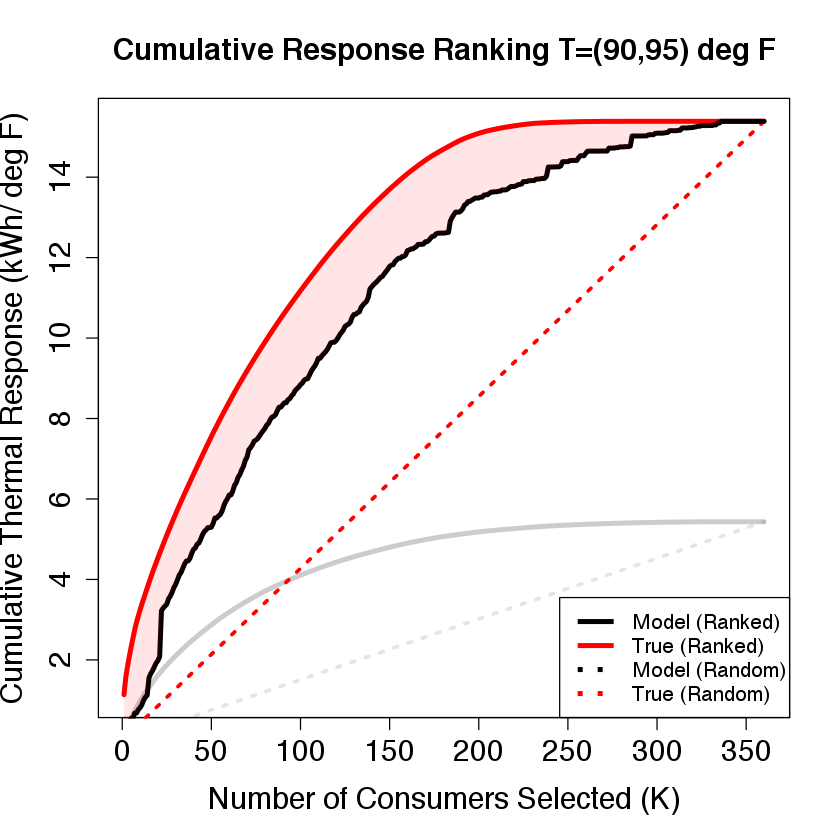

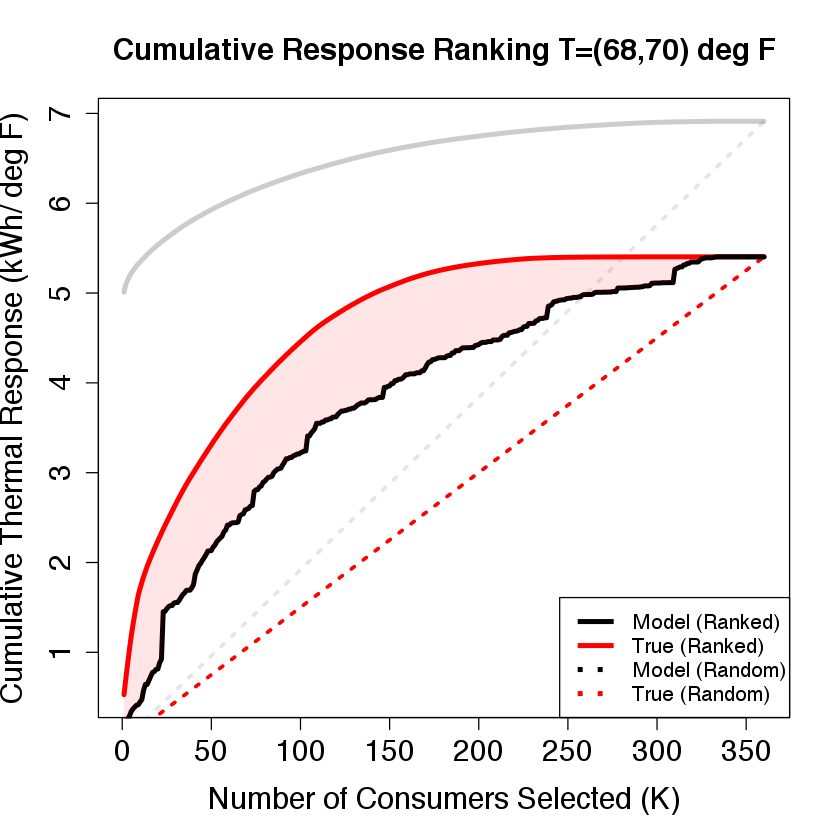

In [32]:
rr1 = rank_contrib_at_k(thermal_model_df, 
                       temp = c(90,95), 
                       var_truth="resp_HVAC", 
                       var_model="resp_avg", res="60min")
rr2 = rank_contrib_at_k(thermal_model_df, 
                       temp = c(68,70), 
                       var_truth="resp_HVAC", 
                       var_model="resp_avg", res="60min")

In [22]:
pdf(file =  paste(PLOT_PATH, "ranking_selection_102F.pdf", sep='/'), 7, 5)
rr = rank_contrib_at_k(thermal_model_df, 
                       temp = c(100,102), 
                       var_truth="resp_HVAC", 
                       var_model="resp_avg", res="60min")
dev.off()

pdf 
  2

In [23]:
pdf(file =  paste(PLOT_PATH, "ranking_selection_82F.pdf", sep='/'), 7, 5)
rr = rank_contrib_at_k(thermal_model_df, 
                       temp = c(80,82), 
                       var_truth="resp_HVAC", 
                       var_model="resp_avg", res="60min")
dev.off()

pdf 
  2

In [24]:
pdf(file =  paste(PLOT_PATH, "ranking_selection_60F.pdf", sep='/'), 7, 5)
rr = rank_contrib_at_k(thermal_model_df, 
                       temp = c(60,62), 
                       var_truth="resp_HVAC", 
                       var_model="resp_avg", res="60min")
dev.off()

pdf 
  2

In [25]:
pdf(file =  paste(PLOT_PATH, "ranking_selection_40F.pdf", sep='/'), 7, 5)
rr = rank_contrib_at_k(thermal_model_df, 
                       temp = c(40,42), 
                       var_truth="resp_HVAC", 
                       var_model="resp_avg", res="60min")
dev.off()

pdf 
  2

In [49]:
delta_resp_60 = list()
delta_resp_15 = list()
temp_range = 40:110
for (t in temp_range) {
    rr1 = rank_contrib_at_k(thermal_model_df, produce_plot=FALSE,
                           temp = c(t-2,t+2), 
                           var_truth="resp_HVAC", 
                           var_model="resp_avg", res="60min")
    names(rr1) <- NULL
    delta_resp_60[[length(delta_resp_60)+1]] = rr1
    rr2 = rank_contrib_at_k(thermal_model_df, produce_plot=FALSE,
                           temp = c(t-2,t+2), 
                           var_truth="resp_HVAC", 
                           var_model="resp_avg", res="15min")
    names(rr2) <- NULL
    delta_resp_15[[length(delta_resp_15)+1]] = rr2
}
delta_resp_15 = data.frame(delta_resp_15); delta_resp_15 = t(delta_resp_15)
delta_resp_60 = data.frame(delta_resp_60);  delta_resp_60 = t(delta_resp_60)
colnames(delta_resp_15) = 1:ncol(delta_resp_15)
colnames(delta_resp_60) = 1:ncol(delta_resp_60)
rownames(delta_resp_15) = temp_range
rownames(delta_resp_60) = temp_range
#delta_resp = rbind(delta_resp_60, delta_resp_15)

In [50]:
fname_1 = paste(PLOT_PATH, "rel_error.pdf", sep='/')
pdf(file = fname_1, 7, 5)
image.plot(as.numeric(colnames(delta_resp_15)), as.numeric(rownames(delta_resp_15)),  t(delta_resp_15),
                 ylab = 'Temperature [deg F]', 
                 xlab = 'Nr. Consumers Selected (K)',
                 main = 'Relative Ranked Thermal Response Error (%)')
dev.off()

pdf 
  2

In [ ]:
delta_resp_15 = cbind(TemperatureF=temp_range, as.numeric(data.frame(do.call(rbind, delta_resp_15))))
delta_resp_60 = cbind(TemperatureF=temp_range, as.numeric(data.frame(do.call(rbind, delta_resp_60))))

In [38]:
str(delta_resp_15)

 num [1:51, 1:360] 0.222 0.016 0 0.604 0.711 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:51] "50" "51" "52" "53" ...
  ..$ : chr [1:360] "1" "2" "3" "4" ...


In [39]:
head(delta_resp_15)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360
50,0.2219994,0.4946493,0.6289959,0.6934628,0.7327005,0.7624157,0.7853181,0.7031021,0.6594519,0.671277,0.6777414,0.6938982,0.7046193,0.5975393,0.6072325,0.6169813,0.6174282,0.6268772,0.630236,0.6344241,0.6358377,0.6024005,0.5872648,0.5928437,0.5814078,0.5862547,0.5923002,0.5846276,0.5897918,0.5950534,0.5995814,0.5716854,0.5743245,0.5783107,0.5816163,0.5841273,0.5585598,0.5576616,0.5608314,0.5637468,0.5662611,0.4760588,0.4781329,0.4810523,0.4835869,0.4833657,0.4836223,0.4848358,0.4853908,0.4879677,0.4780465,0.4761533,0.4768436,0.479139,0.479924,0.4478165,0.4469355,0.4331086,0.4354742,0.3986202,0.3946687,0.3854691,0.387179,0.3869949,0.3892577,0.3888332,0.3803551,0.381957,0.3826044,0.3768716,0.3696103,0.3706043,0.3664363,0.3670506,0.3680088,0.3699452,0.3566586,0.3582914,0.3591218,0.3607158,0.3583617,0.3557793,0.3550862,0.3552579,0.3099311,0.3108172,0.3126095,0.3140414,0.3155177,0.3169183,0.3185469,0.3161815,0.3176633,0.31919,0.3060225,0.3045299,0.3059035,0.3075114,0.3090558,0.3084707,0.3024952,0.301205,0.3026635,0.300254,0.3000323,0.2668145,0.2663934,0.2475861,0.2481958,0.24949,0.2482618,0.2495559,0.249211,0.2504755,0.249868,0.245108,0.2427846,0.2414754,0.2419207,0.2400202,0.2410963,0.2421271,0.2431693,0.2432217,0.2294573,0.2277255,0.2280489,0.2162439,0.2172065,0.2181535,0.2190496,0.2184769,0.2193601,0.2156814,0.2125754,0.2128158,0.2136306,0.212717,0.2134901,0.2142425,0.2149749,0.2157107,0.2121102,0.2128109,0.2092943,0.2055861,0.2034137,0.2038015,0.1817956,0.1813808,0.1783385,0.1787785,0.1792404,0.1797731,0.180352,0.177404,0.1776056,0.1779789,0.1785167,0.1789499,0.1762174,0.1766871,0.1732758,0.1727882,0.1731387,0.1732959,0.166102,0.1663725,0.166787,0.1668784,0.1659603,0.1660753,0.1664652,0.1668237,0.1665035,0.1668446,0.167189,0.1646014,0.1649358,0.1627094,0.16011,0.1602747,0.1605833,0.1579232,0.1580594,0.1571631,0.1548467,0.1551097,0.1547348,0.1540686,0.1542768,0.1522899,0.1511716,0.1491304,0.147165,0.1473917,0.1474316,0.1472078,0.1474179,0.1471371,0.1466236,0.1442377,0.1439139,0.1439836,0.1439717,0.1410713,0.140859,0.1400104,0.1401608,0.1381827,0.1344515,0.1343786,0.1344609,0.134548,0.1340384,0.1299171,0.1291538,0.129268,0.128278,0.1260297,0.1259798,0.1172125,0.1171292,0.1171917,0.1146751,0.1143387,0.1144096,0.09230293,0.09216774,0.0904817,0.09055397,0.08905026,0.08910112,0.08867282,0.08871501,0.08877221,0.08882454,0.08847913,0.08650496,0.08654738,0.08657119,0.08651843,0.08655236,0.08622404,0.08602901,0.08424178,0.08201801,0.08204693,0.08205506,0.08017357,0.07592482,0.07436931,0.0743755,0.07439601,0.06131386,0.06083487,0.06075359,0.06074948,0.06076432,0.06078501,0.06074173,0.06066175,0.06067602,0.0600041,0.05991504,0.05983

##Ranking analysis: relative ordering

Given a model-produced list (in a specified temperature range), take the top K consumers in that list and compare the ranking with the "true" one. Kendall's $\tau$ admits a hypothesis test for which we compute p-values. If $p>0.05$ we reject the null hypothesis $\mathcal{H}_0$ that there is a relation between the two rankings. 

In [43]:
rank_corr_at_k = function(thermal_model_df, 
                          temp = c(65,75), K = NULL, 
                          var_model="resp_avg", var_truth="resp_HVAC", res="60min"){
    cur_df = subset(thermal_model_df, 
                    (TemperatureF >= temp[1]) & (TemperatureF <= temp[2]) & grain==res,
                    select=c("name", "TemperatureF", var_truth, var_model))
    cur_df = t(sapply(split(cur_df,cur_df$name), function(chunk) colMeans(chunk[,c(var_model, var_truth)])))
    if (is.null(K)) K = nrow(cur_df)
    mod_df = cur_df[order(-abs(cur_df[,var_model]))[1:K],]
    tau = cor.test(mod_df[,var_truth], mod_df[,var_model], method = 'kendall', exact = T)
    return(list(df = mod_df, tau = c(estimate=tau$estimate, pval=tau$p.value)))
}
        
# if pval > 0.05 reject H0 

In [52]:
tmp = rank_corr_at_k(thermal_model_df, var_truth="resp_HVAC", var_model="resp_avg", res="60min", temp = c(95, 97))
str(tmp)

Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with ties

List of 2
 $ df : num [1:360, 1:2] 0.1324 0.1269 0.1221 0.1072 0.0999 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:360] "Washington" "Chris" "Clem" "Bruce" ...
  .. ..$ : chr [1:2] "resp_avg" "resp_HVAC"
 $ tau: Named num [1:2] 0.452 0
  ..- attr(*, "names")= chr [1:2] "estimate.tau" "pval"


In [91]:
# compute Kendall's tau for different temperature ranges and values of list cutoff K
k_vec = c(20, 50, 80, 100, 360)
t_vec = 40:110
corr_df = data.frame(matrix(0,nrow=length(t_vec), ncol = length(k_vec)))
names(corr_df) = sprintf("K=%d", k_vec)
rownames(corr_df) = t_vec
for (k in 1:length(k_vec)){
    print(sprintf("K=%d",k_vec[k]))
    for (t in 1:length(t_vec)){
        res = rank_corr_at_k(thermal_model_df, 
                       var_truth="resp_HVAC", 
                       var_model="resp_avg", 
                       res="60min", 
                       K=k_vec[k],
                       temp = c(t_vec[t]-5, t_vec[t]+5))
        if(res$tau['pval']<=0.05) corr_df[t,k] = res$tau['estimate.tau']
    }
}

[1] "K=20"
[1] "K=50"
[1] "K=80"
[1] "K=100"
[1] "K=360"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

In [92]:
ylim = range(corr_df)
cols <- brewer.pal(length(k_vec),"Dark2")
pdf(file =  paste(PLOT_PATH, "kendall_tau_vs_temp_at_k.pdf", sep='/'), 7, 5)
plot(t_vec, corr_df[,1], 
       type='l', lwd=4, lty=1, 
       col=cols[1], 
       ylim=ylim,
    main="Kendall's tau Ranking Correlation",
    xlab="Temperature [deg F]",
    ylab="tau",
    cex.lab=1.5,
    cex.main=1.5,
    cex.axis=1.5)
for (t in 2:ncol(corr_df)){
    points(t_vec, corr_df[,t], lwd=4, col=cols[t], lty=1, type='l')
}
legend("topright", sprintf("K=%d",k_vec), col=cols, lwd=4)
dev.off()

pdf 
  2

Compute rankings using $d_{\text{rank}}$.

In [164]:
length(unique(subset(thermal_model_df, grain=="60min")$name))

[1] 336

In [93]:
head(thermal_model_df)

,TemperatureF,resp_avg,resp_avg.se,resp_MAP,resp_MAP.se,fit_HVAC,resp_HVAC,fit_HV,resp_HV,fit_AC,resp_AC,grain,name,UID
1,1,0.001078776,6.794538e-05,0.0003815989,1.172137e-05,0.002259706,1.032363e-05,0.002265076,1.029737e-05,0,0,15min,Edd,1069
2,2,0.001079216,6.737207e-05,0.0003815989,1.172137e-05,0.002259706,1.032363e-05,0.002265076,1.029737e-05,0,0,15min,Edd,1069
3,3,0.001079462,6.678275e-05,0.0003815989,1.172137e-05,0.002259706,1.032363e-05,0.002265076,1.029737e-05,0,0,15min,Edd,1069
4,4,0.001079513,6.617803e-05,0.0003815989,1.172137e-05,0.002259706,1.032363e-05,0.002265076,1.029737e-05,0,0,15min,Edd,1069
5,5,0.001079366,6.555862e-05,0.0003815989,1.172137e-05,0.002259706,1.032363e-05,0.002265076,1.029737e-05,0,0,15min,Edd,1069
6,6,0.001079022,6.492527e-05,0.0003815989,1.172137e-05,0.002259706,1.032363e-05,0.002265076,1.029737e-05,0,0,15min,Edd,1069


In [167]:
d_rank_k <- function(thermal_model_df, 
                      temp = c(65,75), K = NULL, 
                      var_model="resp_avg", var_truth="resp_HVAC", res="60min"){
    # prepare data
    cur_df = subset(thermal_model_df, 
                    (TemperatureF >= temp[1]) & (TemperatureF <= temp[2]) & grain==res,
                    select=c("name", "TemperatureF", var_truth, var_model))
    y = dcast(cur_df, name ~ var_truth + TemperatureF)
    user_names = as.character(y$name); y$name = NULL
    y = as.numeric(rowMeans(y)); names(y) <- user_names; 
    X = dcast(cur_df, name ~ var_model + TemperatureF)
    rownames(X) <- user_names; X$name = NULL
    names(X) <- sapply(names(X), function(x) tail(strsplit(x, "_")[[1]],1))
    X = as.matrix(X)
    x = as.numeric(rowMeans(X)); names(x) <- user_names; 

    # pick the first K users sorted by model response
    if (is.null(K)) K = length(y)
    idx= order(-abs(x))[1:K]
    y = y[user_names[idx]]
    X = X[user_names[idx],]
    drank = compute_drank(y, t(X), B = 100)
    return(drank)
}
zz = d_rank_k(thermal_model_df, K=10)
    

Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.


In [ ]:
# compute drank for different temperature ranges and values of list cutoff K
k_vec <- c(5, 10, 15, 20, 30, 50, 80, 100, 150, 336)
t_vec <- seq(40,110, 5)
drank_d <- data.frame(matrix(0,nrow=length(t_vec), ncol = length(k_vec)))
drank_p <- data.frame(matrix(0,nrow=length(t_vec), ncol = length(k_vec)))
for (k in 1:length(k_vec)){
    print(sprintf("K=%d",k_vec[k]))
    for (t in 1:length(t_vec)){
        res <- d_rank_k(thermal_model_df, 
                       var_truth="resp_HVAC", 
                       var_model="resp_avg", 
                       res="60min", 
                       K=k_vec[k],
                       temp = c(t_vec[t]-1, t_vec[t]+1))
        drank_p[t,k] <- res['p']
        drank_d[t,k] <- res['d']
    }
}


[1] "K=5"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to overrid

[1] "K=10"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to overrid

[1] "K=15"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to overrid

[1] "K=20"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to overrid

[1] "K=30"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to overrid

[1] "K=50"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to overrid

[1] "K=80"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to overrid

[1] "K=100"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to overrid

[1] "K=150"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to overrid

[1] "K=336"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.


In [93]:
names(drank_d) <- sprintf("K=%d", k_vec)
rownames(drank_d) <- t_vec
names(drank_p) <- sprintf("K=%d", k_vec)
rownames(drank_p) <- t_vec


In [110]:
write.csv(drank_d, file=paste(PLOT_PATH, "drank_computations.csv", sep="/"))

In [109]:
write.csv(drank_p, file=paste(PLOT_PATH, "drank_computations_pvals.csv", sep="/"))

In [111]:
drank_d

,K=5,K=10,K=15,K=20,K=30,K=50,K=80,K=100,K=150,K=360
40,3880.164,3880.164,3880.164,3880.164,3880.164,3880.164,3880.164,3880.164,3880.164,3880.164
45,3880.79,3880.79,3880.79,3880.79,3880.79,3880.79,3880.79,3880.79,3880.79,3880.79
50,3881.352,3881.352,3881.352,3881.352,3881.352,3881.352,3881.352,3881.352,3881.352,3881.352
55,3881.654,3881.654,3881.654,3881.654,3881.654,3881.654,3881.654,3881.654,3881.654,3881.654
60,3881.771,3881.771,3881.771,3881.771,3881.771,3881.771,3881.771,3881.771,3881.771,3881.771
65,3881.654,3881.654,3881.654,3881.654,3881.654,3881.654,3881.654,3881.654,3881.654,3881.654
70,3881.563,3881.563,3881.563,3881.563,3881.563,3881.563,3881.563,3881.563,3881.563,3881.563
75,1316.246,1316.246,1316.246,1316.246,1316.246,1316.246,1316.246,1316.246,1316.246,1316.246
80,182.824,182.824,182.824,182.824,182.824,182.824,182.824,182.824,182.824,182.824
85,245.9242,245.9242,245.9242,245.9242,245.9242,245.9242,245.9242,245.9242,245.9242,245.9242


In [101]:
?image.plot

image.plot {fields},R Documentation
...,"The usual arguments to the image function as x,y,or z or as a list with x,y,z as components. One can also include a breaks an argument for an unequal spaced color scale with color scale boundaries at the breaks (see example below). If a ""quadrilateral grid"", arguments must be explicitly x,y and z with x, and y being matrices of dimensions equal to, or one more than, z giving the grid locations. The basic concept is that the coordinates of x and y still define a grid but the image cells are quadrilaterals rather than being restricted to rectangles. See details below as to how one handles whether the quads are specified by their vertices or by their midpoints. NOTE graphical argruments passed here will only have impact on the image plot. To change the graphical defaults for the legend use the par function beforehand e.g. par( lab.cex=2.0) to increase colorbar labels."
add,If true add image and a legend strip to the existing plot.
bigplot,Plot coordinates for image plot. If not passed these will be determined within the function.
border,This only works if x and y are matrices – if NA the quadralaterals will have a border color that is the same as the interior color. Otherwise this specifies the color to use.
breaks,Break points in sorted order to indicate the intervals for assigning the colors. Note that if there are nlevel colors there should be (nlevel+1) breakpoints. If breaks is not specified (nlevel+1) equally spaced breaks are created where the first and last bin have their midpoints at the minimum and maximum values in z or at zlim.
col,Color table to use for image (See help file on image for details.). Default is a pleasing range of 64 divisions suggested by Tim Hoar and is similar to the MATLAB (TM) jet color scheme. Note that if breaks is specified there must be one less colors specified than the number of breaks.
graphics.reset,If FALSE (default) the plotting region ( plt in par) will not be reset and one can add more information onto the image plot. (e.g. using functions such as points or lines.) If TRUE will reset plot parameters to the values before entering the function.
horizontal,If false (default) legend will be a vertical strip on the right side. If true the legend strip will be along the bottom.
lab.breaks,If breaks are supplied these are text string labels to put at each break value. This is intended to label axis on a transformed scale such as logs.
axis.args,Additional arguments for the axis function used to create the legend axis. (See example below adding a log scaling.)


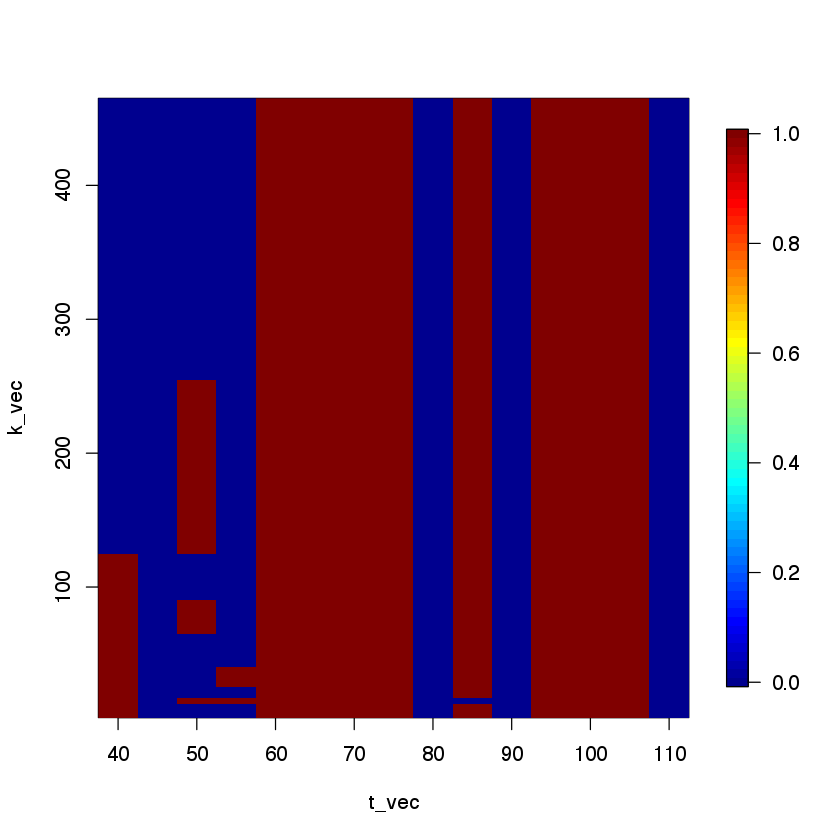

In [102]:
image.plot(t_vec, k_vec, 1 * drank_p > 0.5)

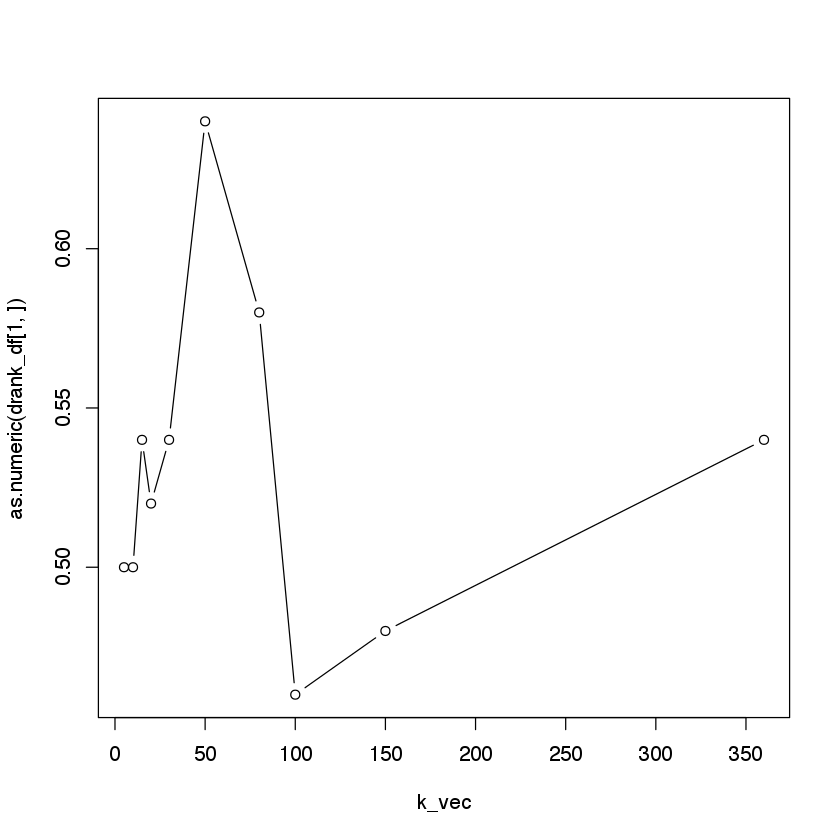

In [53]:
plot(k_vec, as.numeric(drank_df[1,]), type='b')
points(k_vec, as.numeric(drank_df[11,]), type='b', col='blue')


In [59]:
drank_df

,K=5,K=10,K=15,K=20,K=30,K=50,K=80,K=100,K=150,K=360
40,0.5,0.5,0.54,0.52,0.54,0.64,0.58,0.46,0.48,0.54
45,0.32,0.32,0.32,0.4,0.4,0.28,0.3,0.32,0.24,0.2
50,0.42,0.34,0.36,0.48,0.46,0.5,0.36,0.52,0.56,0.5
55,0.46,0.44,0.48,0.4,0.54,0.52,0.42,0.58,0.48,0.44
60,1,0.94,1,0.92,1,0.9,0.88,0.96,0.94,1
65,1,1,1,1,1,1,1,1,1,1
70,0.88,0.84,0.86,0.88,0.86,0.88,0.82,0.82,0.86,0.84
75,0.84,0.78,0.78,0.84,0.84,0.9,0.88,0.86,0.82,0.86
80,0.44,0.36,0.42,0.44,0.38,0.42,0.32,0.3,0.42,0.42
85,0.38,0.5,0.44,0.38,0.58,0.48,0.6,0.6,0.5,0.48


In [27]:
drank_df[6,]

,K=20,K=50,K=80,K=100,K=360
45,0.9,0.88,0.9,0.88,0.8


In [29]:
drank_df[4,]

,K=20,K=50,K=80,K=100,K=360
43,0.2,0.28,0.16,0.28,0.32


In [194]:
head(drank_df)

,X1,X2,X3,X4,X5
1,0.4,0.26,0.18,0.16,0.32
2,0.92,0.92,0.84,0.84,0.92
3,0.98,0.96,0.92,1,0.98
4,0.22,0.22,0.18,0.22,0.2
5,0.52,0.4,0.4,0.5,0.5
6,0.92,0.8,0.78,0.8,0.86


##Ranking example

In [ ]:
subset(thermal_model_df